In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import networkx as nx
import zipfile
import time
import sys
import math
import tracemalloc
import psutil
import gc
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [46]:
zip_path = "/Users/andy/Desktop/ds5230/hw2/Groceries_dataset.csv.zip"

with zipfile.ZipFile(zip_path, "r") as zf:
    csv_name = next((n for n in zf.namelist() if n.lower().endswith(".csv")), None)
    with zf.open(csv_name) as f:
        df = pd.read_csv(f)

# norm columns and create transaction IDs
df.columns = [c.lower() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], format='%d-%m-%Y', errors="coerce").astype(str)
df["tid"] = df["member_number"].astype(str) + "_" + df["date"]
# group items by transaction
tid_to_items = dict(df.groupby("tid")["itemdescription"].agg(lambda s: frozenset(map(str, s))))
print(f"Loaded {len(tid_to_items)} transactions")
print(f"Total items purchased: {len(df)}")
print(f"Unique products: {df['itemdescription'].nunique()}")
print(f"Avg items per transaction: {len(df) / len(tid_to_items):.2f}")

Loaded 14963 transactions
Total items purchased: 38765
Unique products: 167
Avg items per transaction: 2.59


In [47]:
# item -> set of transaction IDs
item_to_tids = defaultdict(set)
for tid, items in tid_to_items.items():
    for item in items:
        item_to_tids[item].add(tid)

item_to_tids = dict(item_to_tids)
n_trans = len(tid_to_items)
print(f"Unique items: {len(item_to_tids)}")

Unique items: 167


In [48]:
# ECLAT with specified minimum support
def run_eclat(item_to_tids, min_supp):
    N = n_trans
    minsup_count = math.ceil(min_supp * N)
    
    # find frequent 1-itemsets
    L1 = [(tuple([item]), tids) for item, tids in item_to_tids.items() 
          if len(tids) >= minsup_count]
    L1.sort(key=lambda kv: len(kv[1]))
    
    freq = {}
    stack = [(tuple(), set(), L1)]
    
    while stack:
        pre_items, pre_ids, tail = stack.pop()
        
        if pre_items:
            freq[pre_items] = len(pre_ids) / N
        
        for j in range(len(tail)):
            i_j, id_j = tail[j]
            new_tids = id_j if not pre_items else (pre_ids & id_j)
            
            if len(new_tids) >= minsup_count:
                new_prefix = pre_items + (i_j,)
                stack.append((new_prefix, new_tids, tail[j + 1:]))
    
    return freq

sup_lv = [0.10, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001]
results = []

for min_sup in sup_lv:
    start = time.time()
    freq = run_eclat(item_to_tids, min_sup)
    elapsed = time.time() - start
    results.append({'support': min_sup, 'itemsets': len(freq), 'time': elapsed})
    print(f"Support={min_sup:.3f}: {len(freq):5d} itemsets, time={elapsed:.3f}s")

Support=0.100:     3 itemsets, time=0.000s
Support=0.080:     5 itemsets, time=0.001s
Support=0.060:     9 itemsets, time=0.002s
Support=0.050:    11 itemsets, time=0.001s
Support=0.040:    16 itemsets, time=0.002s
Support=0.030:    27 itemsets, time=0.005s
Support=0.020:    38 itemsets, time=0.007s
Support=0.010:    69 itemsets, time=0.014s
Support=0.005:   126 itemsets, time=0.017s
Support=0.001:   750 itemsets, time=0.027s


In [49]:
# try different support thresholds and measure performance
support_thresholds = [0.1, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.008, 0.005, 0.003, 0.001]
performance_results = []

print("="*80)
print("="*80)

for min_sup in support_thresholds:
    gc.collect()
    tracemalloc.start()
    mem_before = psutil.Process().memory_info().rss / 1024 / 1024  
    start_time = time.time()
    freq = run_eclat(item_to_tids, min_sup)
    elapsed_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    mem_after = psutil.Process().memory_info().rss / 1024 / 1024  
    size_dist = Counter(len(itemset) for itemset in freq.keys())
    num_rules = 0
    if len(freq) < 5000:
        temp_rules = []
        for items, s_xy in freq.items():
            if len(items) >= 2:
                num_rules += sum(1 for r in range(1, len(items)))
    
    result = {
        'min_supp': min_sup,
        'min_count': int(min_sup * n_trans),
        'num_itemsets': len(freq),
        'time_sec': elapsed_time,
        'memory_mb': peak / 1024 / 1024,
        'memory_used': mem_after - mem_before,
        'max_itemset_size': max(size_dist.keys()) if size_dist else 0,
        '1-itemsets': size_dist.get(1, 0),
        '2-itemsets': size_dist.get(2, 0),
        '3-itemsets': size_dist.get(3, 0),
        '4+-itemsets': sum(v for k, v in size_dist.items() if k >= 4),
        'potential_rules': num_rules
    }
    
    performance_results.append(result)
    print(f"MinSup={min_sup:6.3f} ({result['min_count']:4d} trans) | "
          f"Itemsets={result['num_itemsets']:5d} | "
          f"Time={elapsed_time:6.3f}s | "
          f"Memory={result['memory_mb']:.1f}MB | "
          f"MaxSize={result['max_itemset_size']}")

perf_df = pd.DataFrame(performance_results)

MinSup= 0.100 (1496 trans) | Itemsets=    3 | Time= 0.001s | Memory=0.0MB | MaxSize=1
MinSup= 0.080 (1197 trans) | Itemsets=    5 | Time= 0.000s | Memory=0.0MB | MaxSize=1
MinSup= 0.060 ( 897 trans) | Itemsets=    9 | Time= 0.001s | Memory=0.0MB | MaxSize=1
MinSup= 0.050 ( 748 trans) | Itemsets=   11 | Time= 0.002s | Memory=0.0MB | MaxSize=1
MinSup= 0.040 ( 598 trans) | Itemsets=   16 | Time= 0.003s | Memory=0.0MB | MaxSize=1
MinSup= 0.030 ( 448 trans) | Itemsets=   27 | Time= 0.007s | Memory=0.0MB | MaxSize=1
MinSup= 0.020 ( 299 trans) | Itemsets=   38 | Time= 0.011s | Memory=0.0MB | MaxSize=1
MinSup= 0.015 ( 224 trans) | Itemsets=   50 | Time= 0.021s | Memory=0.0MB | MaxSize=1
MinSup= 0.010 ( 149 trans) | Itemsets=   69 | Time= 0.031s | Memory=0.1MB | MaxSize=2
MinSup= 0.008 ( 119 trans) | Itemsets=   82 | Time= 0.024s | Memory=0.1MB | MaxSize=2
MinSup= 0.005 (  74 trans) | Itemsets=  126 | Time= 0.029s | Memory=0.1MB | MaxSize=2
MinSup= 0.003 (  44 trans) | Itemsets=  216 | Time= 0.

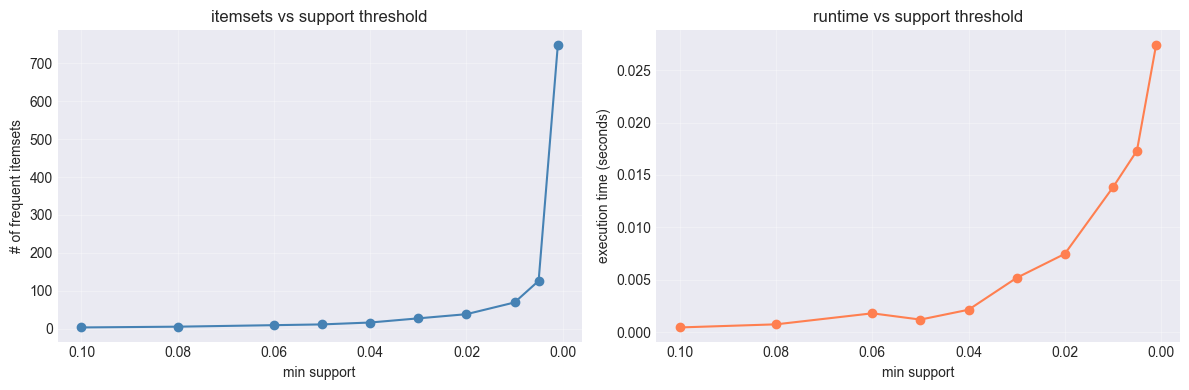

In [50]:
results_df = pd.DataFrame(results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(results_df['support'], results_df['itemsets'], 'o-', color='steelblue')
ax1.set_xlabel('min support')
ax1.set_ylabel('# of frequent itemsets')
ax1.set_title('itemsets vs support threshold')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)
ax2.plot(results_df['support'], results_df['time'], 'o-', color='coral')
ax2.set_xlabel('min support')
ax2.set_ylabel('execution time (seconds)')
ax2.set_title('runtime vs support threshold')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [51]:
min_supp = 0.001
freq = run_eclat(item_to_tids, min_supp)
size_dist = Counter(len(itemset) for itemset in freq.keys())
print(f"there are {len(freq)} frequent itemsets at support={min_supp}")
print("\nitemset size distribution:")
for size in sorted(size_dist.keys()):
    print(f"  size {size}: {size_dist[size]} itemsets")

there are 750 frequent itemsets at support=0.001

itemset size distribution:
  size 1: 149 itemsets
  size 2: 592 itemsets
  size 3: 9 itemsets


In [52]:
# now lets generate association rules
rules = []
for items, s_xy in freq.items():
    if len(items) < 2:
        continue
    
    for r in range(1, len(items)):
        for X in combinations(items, r):
            X = tuple(sorted(X))
            Y = tuple(sorted(set(items) - set(X)))
            s_x = freq.get(X, 0.0)
            s_y = freq.get(Y, 0.0)
            
            if s_x > 0 and s_y > 0:
                conf = s_xy / s_x
                lift = conf / s_y
                
                # only keep meaningful rules
                if conf >= 0.2 and lift >= 1.2:
                    rules.append({
                        'antecedent': X,
                        'consequent': Y,
                        'support': s_xy,
                        'confidence': conf,
                        'lift': lift,
                        'count': int(s_xy * n_trans)
                    })

# sort by lift
rules.sort(key=lambda x: x['lift'], reverse=True)
print(f"Found {len(rules)} association rules")

Found 1 association rules


In [53]:
if rules:

    rules_val = []
    for rule in rules[:20]:
        rules_val.append({
            'Antecedent': str(rule['antecedent']),
            'Consequent': str(rule['consequent']),
            'Support': f"{rule['support']:.4f}",
            'Confidence': f"{rule['confidence']:.3f}",
            'Lift': f"{rule['lift']:.2f}",
            'Count': rule['count']
        })
    
    rules_df = pd.DataFrame(rules_val)
    print(f"Found {len(rules)} association rules\n")
    print("Top 20 Association Rules (sorted by lift):")
    print(rules_df.to_string(index=False))

Found 1 association rules

Top 20 Association Rules (sorted by lift):
                 Antecedent         Consequent Support Confidence Lift  Count
(('sausage',), ('yogurt',)) (('whole milk',),)  0.0015      0.256 1.62     22


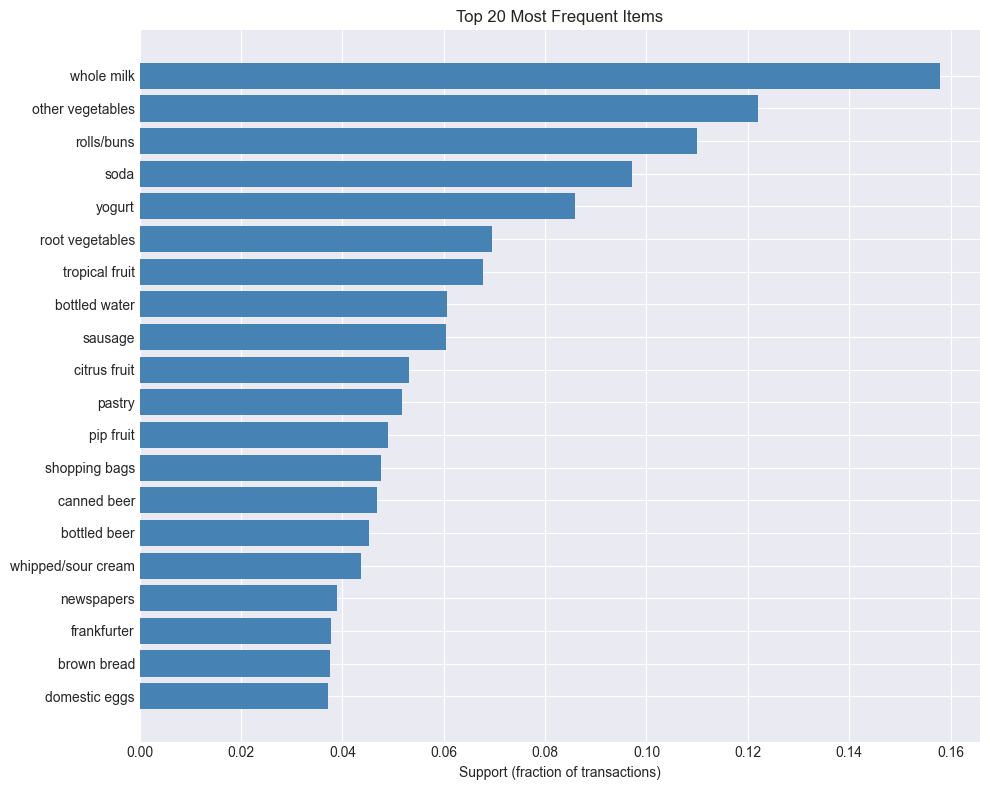

In [54]:
item_freq = {item: len(tids)/n_trans for item, tids in item_to_tids.items()}
top_items = sorted(item_freq.items(), key=lambda x: x[1], reverse=True)[:20]
plt.figure(figsize=(10, 8))
items, supports = zip(*top_items)
plt.barh(range(len(items)), supports, color='steelblue')
plt.yticks(range(len(items)), items)
plt.xlabel('Support (fraction of transactions)')
plt.title('Top 20 Most Frequent Items')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


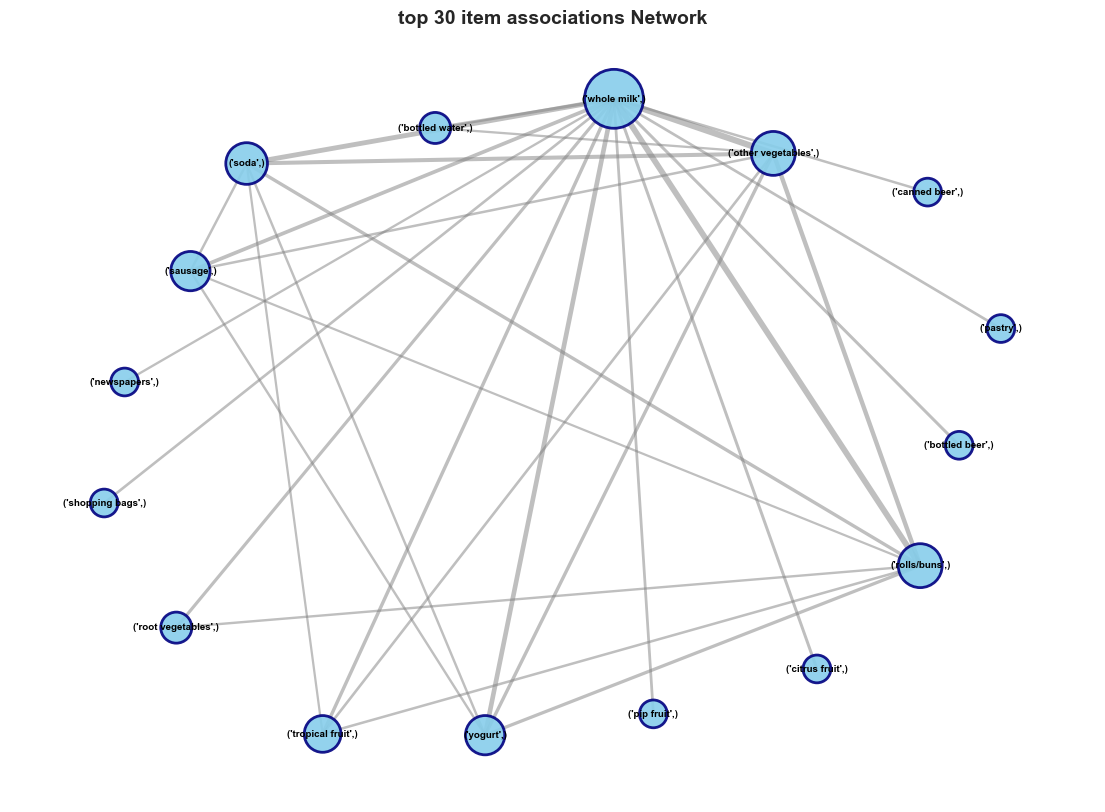

network from top pairs: 16 nodes, 30 edges


In [55]:
# build network from top 30 pairs
G2 = nx.Graph()

all_pairs = [(items, supp) for items, supp in freq.items() if len(items) == 2]
all_pairs.sort(key=lambda x: x[1], reverse=True)
top_n_pairs = all_pairs[:30]  

if top_n_pairs:
    for (i_1, i_2), supp in top_n_pairs:
        G2.add_node(i_1)
        G2.add_node(i_2)
        G2.add_edge(i_1, i_2, weight=supp)
    
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G2, k=2, iterations=50)
    node_sizes = [300 + 100 * G2.degree(node) for node in G2.nodes()]
    nx.draw_networkx_nodes(G2, pos, node_color='skyblue', node_size=node_sizes,
                          alpha=0.9, edgecolors='navy', linewidths=2)
    
    edges = G2.edges()
    weights = [G2[u][v]['weight'] * 300 for u, v in edges]
    nx.draw_networkx_edges(G2, pos, width=weights, alpha=0.5, edge_color='gray')
    
    nx.draw_networkx_labels(G2, pos, font_size=7, font_weight='bold')
    
    plt.title(f'top {len(top_n_pairs)} item associations Network', 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    print(f"network from top pairs: {G2.number_of_nodes()} nodes, {G2.number_of_edges()} edges")
else:
    print("failed.")